In [4]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 

In [5]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=True
)

test_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=False
)

--2021-10-02 14:28:35--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-10-02 14:28:35--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [          <=>       ]  33.20M  16.5MB/s    in 2.0s    

2021-10-02 14:28:38 (16.5 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=False)

In [8]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(48, 1, kernel_size=1), nn.Tanh()
        
    )
  def forward(self, x):
    perturbation = self.net(x)
    return perturbation

In [9]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(48, 96, kernel_size=3), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = F.softmax(self.net(x), dim=1)
    return logits.view(-1, 10)

In [10]:
# HYPERPARAMETERS
epochs = 10
epsilon = 0.1
alpha = 0.5
cg = 0.5
k = 1
generator = Generator().cuda()
classifier = Classifier().cuda()
# Standard (non-adversarial) training loop
def train(device, train_loader):
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-6)
  classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
  loss = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    for i, (x,y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)

      generator_optimizer.zero_grad()
      perturbation = generator(x)
      probs = F.softmax(classifier(x + perturbation), dim=1)
      batch_loss = probs + cg * torch.norm(perturbation, p=2)
      gen_loss = batch_loss.mean()
      gen_loss.backward()
      generator_optimizer.step()

      """try:
        x, y = next(train_loader_iter)
      except StopIteration:
        train_loader_iter = iter(train_loader)
        x, y = next(train_loader_iter)
      x,y = x.to(device), y.to(device)"""
      classifier_optimizer.zero_grad()
      perturbation = generator(x)
      classifier_loss = alpha * loss(classifier(x), y) + (1-alpha) * loss(classifier(x+perturbation), y)
      classifier_loss.backward()
      classifier_optimizer.step()      
      if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Generator_loss: {}, Classifier_loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), gen_loss, classifier_loss))


In [11]:
train(device, train_loader) 

Epoch [1/10], Step [1/469], Generator_loss: 7.152390956878662, Classifier_loss: 2.3023877143859863
Epoch [1/10], Step [101/469], Generator_loss: 6.813683986663818, Classifier_loss: 2.2250518798828125
Epoch [1/10], Step [201/469], Generator_loss: 6.471032619476318, Classifier_loss: 2.0742838382720947
Epoch [1/10], Step [301/469], Generator_loss: 6.08203649520874, Classifier_loss: 2.0970022678375244
Epoch [1/10], Step [401/469], Generator_loss: 5.608693599700928, Classifier_loss: 2.0012450218200684
Epoch [2/10], Step [1/469], Generator_loss: 5.204819679260254, Classifier_loss: 1.7892394065856934
Epoch [2/10], Step [101/469], Generator_loss: 4.474880218505859, Classifier_loss: 1.713665246963501
Epoch [2/10], Step [201/469], Generator_loss: 3.7151544094085693, Classifier_loss: 1.7457740306854248
Epoch [2/10], Step [301/469], Generator_loss: 3.020357131958008, Classifier_loss: 1.6237984895706177
Epoch [2/10], Step [401/469], Generator_loss: 2.3968136310577393, Classifier_loss: 1.65294623374

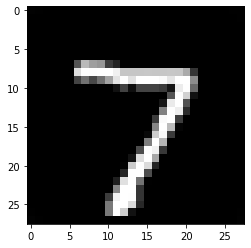

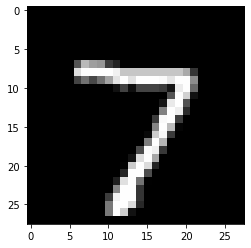

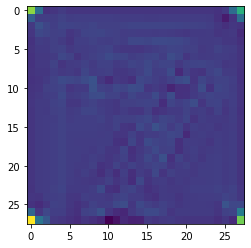

0.016946662


In [12]:
for x,y in test_loader:
  x,y = x.to(device), y.to(device)
  perturbation = generator(x)
  image = (x + perturbation).detach().cpu().numpy()
  original = x[0][0].cpu().numpy()
  plt.imshow(image[0][0], cmap='gray')
  plt.show()
  plt.imshow(original, cmap='gray')
  plt.show()
  plt.imshow((image-original)[0][0])
  plt.show()
  print(np.linalg.norm((image-original)[0][0], ord=2))
  break

In [13]:
class BaseClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(48, 96, kernel_size=3), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = F.softmax(self.net(x), dim=1)
    return logits.view(-1, 10)

In [21]:
baseClassifier = BaseClassifier().cuda()
def train_base(device, train_loader):
  classifier_optimizer = torch.optim.Adam(baseClassifier.parameters(), lr=1e-3)
  loss = nn.CrossEntropyLoss()
  for epoch in range(epochs):
    for i, (x,y) in enumerate(train_loader):
      x, y = x.to(device), y.to(device)
      classifier_optimizer.zero_grad()
      classifier_loss = loss(baseClassifier(x), y) 
      classifier_loss.backward()
      classifier_optimizer.step()      
      if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), classifier_loss))


In [22]:
train_base(device, train_loader)

Epoch [1/10], Step [1/469], Classifier_loss: 2.3021018505096436
Epoch [1/10], Step [101/469], Classifier_loss: 2.016310214996338
Epoch [1/10], Step [201/469], Classifier_loss: 2.084836959838867
Epoch [1/10], Step [301/469], Classifier_loss: 1.9202932119369507
Epoch [1/10], Step [401/469], Classifier_loss: 1.9438130855560303
Epoch [2/10], Step [1/469], Classifier_loss: 2.002037286758423
Epoch [2/10], Step [101/469], Classifier_loss: 1.9903645515441895
Epoch [2/10], Step [201/469], Classifier_loss: 1.9259456396102905
Epoch [2/10], Step [301/469], Classifier_loss: 1.836113452911377
Epoch [2/10], Step [401/469], Classifier_loss: 1.8242815732955933
Epoch [3/10], Step [1/469], Classifier_loss: 1.850592851638794
Epoch [3/10], Step [101/469], Classifier_loss: 1.8252578973770142
Epoch [3/10], Step [201/469], Classifier_loss: 1.8615632057189941
Epoch [3/10], Step [301/469], Classifier_loss: 1.8342620134353638
Epoch [3/10], Step [401/469], Classifier_loss: 1.7241915464401245
Epoch [4/10], Step [1

In [23]:
base_classifier_loss  = 0
adv_classifier_loss = 0 
loss = nn.CrossEntropyLoss()
for x,y in test_loader:
  x,y = x.to(device), y.to(device)
  perturbation = generator(x)
  perturbed_image = x + perturbation
  base_classifier_loss += loss(baseClassifier(x), y)
  adv_classifier_loss += loss(classifier(x), y)

In [27]:
print("Adversarial classifier loss: ", adv_classifier_loss.detach().cpu().numpy(), "||| Base classifier loss: ", base_classifier_loss.detach().cpu().numpy())

Adversarial classifier loss:  117.13299 ||| Base classifier loss:  124.39505


Now, let's take random samples from the test set and inspect their behavior under adversarial perturbations. 

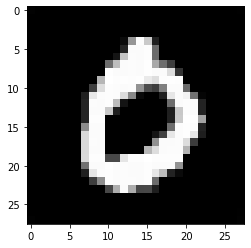

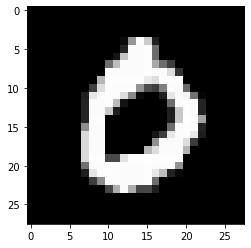

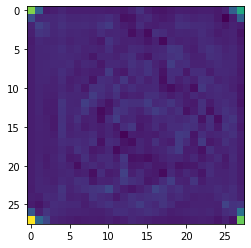

0.016742798
torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 0.9995, 1.0000, 1.0000, 1.0000, 0.9730, 0.9996,
        1.0000, 0.5961, 1.0000, 1.0000, 0.6279, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9925, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9987, 0.9999,
        1.0000, 0.9889, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 0.9996, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9795, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 0.9215,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000, 0.6931,
        1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9071, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.999

In [38]:
#To see the adversarial examples, choose the index from [3, 10, 13, 18]
i = 3
for x, y in test_loader:
  x,y = x.to(device), y.to(device)
  perturbation = generator(x)
  perturbed_image = x + perturbation
  base_pred = baseClassifier(x)
  adv_pred = classifier(x)

  image = (perturbed_image).detach().cpu().numpy()
  original = x[i][0].cpu().numpy()
  plt.imshow(image[i][0], cmap='gray')
  plt.show()
  plt.imshow(original, cmap='gray')
  plt.show()
  plt.imshow((image-original)[i][0]) #perturbation visualization
  plt.show()
  print(np.linalg.norm((image-original)[i][0], ord=2))
  print(torch.max(base_pred.data,1))
  print(torch.max(adv_pred.data,1))
  print(y)
  break


  i+=1
